In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import pandas_datareader.data as web
%pylab inline
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


# A longwinded note on the structure of this tutorial

This presentation is intended as a first look at tensorflow. It should provide enough foundation to let the student start exploring the documentation themselves. This should be reinforced by maybe 20 minutes of "playing around" in a notebook to solidify the concepts. 

Documentation of Tensorflow can be found on their website. Its very useful but, since it's a huge project, can be tough to work through. It helps to know that tensorflow is actually a collection of APIs starting with TensorFlow Core and working up to varying levels of abstraction. Some of the mid-level APIs, such as `tf.train` and `tf.nn` are commonly used even in research level. 

When learning tensorflow we can either start from the top or bottom (high level API or core API). Both methods have their advantages but I have chosen the latter. We will begin with the basic funcionality of the Core API and a few other APIs that help with basic mathematical operations. In later lessons we will work up to higher level APIs, but wherever possible, we will first run some basic code in Core API that does the same as the higher level function. For the student who gets bogged down by rigorous math: although occaisionally frustrating, she should keep in mind that pretty much every "mathy bit" will get redefined later as a one-line abstraction. 

This method is intended to avoid letting any part of the process become a "black box". Once we move on to deep learning this will be vital because it allows us to poke around inside our model and figure out if it is training correctly.

# Intro

## basic tensorflow intuition

Those who have experience with numpy will be familiar with most of the functions and operations. The rest of us have experience with other forms of processing data, manipulating dataframes, matrices, and arrays in whatever language and package. 

Tensorflow will be the same as this, but with one more layer of required intuition: the idea of **graph based computation**. 

Think of it like this: instead of having objects that hold data and functions that manipulate the objects to create new objects, we have **tensors** which hold a graph of all the functions that will arrive to that point. Calling the tensor itself does nothing, instead we have to **run the function in a Session**.

### constants and operations

In [2]:
x = tf.constant(4)
y = tf.constant(5)

In [3]:
x

<tf.Tensor 'Const:0' shape=() dtype=int32>

In [4]:
x+y

<tf.Tensor 'add:0' shape=() dtype=int32>

In [5]:
sess = tf.Session()
sess.run(x+y)

9

Constants can have rank 0 or greater. Lets check out a rank two constant:

In [6]:
Z = tf.constant([[1,2],[3,4]])

In [7]:
sess.run(tf.multiply(x,Z)) # x * Z also works (abreviated syntax)

array([[ 4,  8],
       [12, 16]], dtype=int32)

There are lots of functions for data manipulation: addition, multiplication, exponents, etc. Look at the documentation for descriptions for what they are. For example:

In [8]:
sess.run(tf.pow(Z, x)) # = Z^x

array([[  1,  16],
       [ 81, 256]], dtype=int32)

### placeholders
Placeholders are empty dataframes where we input the data when we run the process. This is vital to the workflow in tensorflow. We usually use them as the "input and output" sets. In  `Y = M*X + b` the placeholders would be X and Y. The placeholders can hold lots of data so the model runs **batches** as we will see.

In [9]:
X = tf.placeholder(dtype = tf.float32)
Y = tf.placeholder(dtype = tf.float32)

In [10]:
sess.run(X+Y, {X:[0,1,2], Y:[3,4,5]})

array([ 3.,  5.,  7.], dtype=float32)

### Variables
These are the **trainable** parameters of the model. They must be **initialized** to a certain value before being used.  

In [11]:
M = tf.Variable([.01], dtype = tf.float32)

In [12]:
init = tf.global_variables_initializer()
sess.run(init)

In [13]:
sess.run(M + X, {X: [0,1,2,3]})

array([ 0.01      ,  1.00999999,  2.00999999,  3.00999999], dtype=float32)

After initialization, variables can be assigned to a new value. This is what "training" is: slowly changing the trainable variables.

In [14]:
update_M = tf.assign_add(M, [2])
for i in range(10):
    print(sess.run(M + X, {X: [0,1,2,3]}))
    sess.run(update_M)

[ 0.01        1.00999999  2.00999999  3.00999999]
[ 2.00999999  3.00999999  4.01000023  5.01000023]
[ 4.01000023  5.01000023  6.01000023  7.01000023]
[ 6.01000023  7.01000023  8.01000023  9.01000023]
[  8.01000023   9.01000023  10.01000023  11.01000023]
[ 10.01000023  11.01000023  12.01000023  13.01000023]
[ 12.01000023  13.01000023  14.01000023  15.01000023]
[ 14.01000023  15.01000023  16.01000023  17.01000023]
[ 16.01000023  17.01000023  18.01000023  19.01000023]
[ 18.01000023  19.01000023  20.01000023  21.01000023]


It is best practices to initialize a Variable using `tf.get_variable` and to assign it a name and datatype. The default initializer is random_uniform but we can change that 

In [15]:
my_v = tf.get_variable("my_v", [1,2,3])

In [16]:
my_v

<tf.Variable 'my_v:0' shape=(1, 2, 3) dtype=float32_ref>

In [17]:
#dont forget to initialize!
init = tf.global_variables_initializer()
sess.run(init)

In [18]:
sess.run(my_v)

array([[[-0.5787527 , -0.34723955,  0.8445853 ],
        [-0.38655049, -1.0259459 , -0.76001722]]], dtype=float32)

# Time to make a linear regression, boludo

In [19]:
# training data
x_train = [0.0,1.0,2.0,3.0]
y_train = [4.0,5.0,6.0,7.0]

In [20]:
# 1 MODEL
x = tf.placeholder(dtype = tf.float32, shape = [None,])
y = tf.placeholder(dtype = tf.float32, shape = [None,])
M = tf.get_variable("M", dtype = tf.float32, initializer=tf.constant([0.1]))
b = tf.get_variable("b", dtype = tf.float32, initializer=tf.constant([0.1]))
linear_model = M * x + b

In [22]:
# example
init = tf.global_variables_initializer()
sess.run(init)
sess.run(tf.assign_add(M,[2]))
sess.run(linear_model, {x: [1,2]})

array([ 2.19999981,  4.29999971], dtype=float32)

In [23]:
# 2 LOSS
sq_error = (y - linear_model)**2
loss = tf.reduce_mean(sq_error)

In [24]:
# 3 OPTIMIZER
## this is the CANCHERO VERSION OF GRADIENT_DESCENT OPTIMIZER in order to show the math... the more commonly used one is below, 
## but I wanted to show the functionality of the basic API. Most tutorials dont even bother showing this becuase
## its not practical
step = .01 # HYPERPARAM ALERT!!! also note: this will often be even smaller
g = tf.gradients(loss, [M,b]) # computes the gradient (vector of partial derivatives) of the loss function w.r.t. the variables M and b. Computed through the magic of back propagation
assign_M = tf.assign_sub(M, g[0]*[step]) # subtracts (dL/dM) * step) from M and assigns that as the new M
assign_b = tf.assign_sub(b, g[1]*[step]) # subtracts (dL/db) * step) from b and assigns that as the new b
def train_canchero():
    return assign_M, assign_b

In [25]:
# init
init = tf.global_variables_initializer()
sess.run(init)

In [26]:
# iterate through the training step 
for i in range(1000):
    sess.run(train_canchero(), {x: x_train, y: y_train})
   

In [27]:
print(sess.run(M), sess.run(b)) # thats pretty close to what we'd expect!

[ 1.00342476] [ 3.99268842]


We will probably always use the **train** api instead of the canchero version. Its much easier and not error prone. 

In [28]:
# 3 OPTIMIZER
## Essentially all this does is (1) get the gradient of the loss function wrt variables (2) step the variable accordingly
optimizer = tf.train.GradientDescentOptimizer(0.01) # step param
train = optimizer.minimize(loss) # note: this automatically runs it on ALL variables, that's why we dont have to tell it which ones

In [29]:
# init again and run
init = tf.global_variables_initializer()
sess.run(init)
for i in range(10000):
    sess.run(train, {x: x_train, y: y_train})
print(sess.run(M), sess.run(b))

[ 1.0000093] [ 3.99998021]


Finally, I marked the three essencial modules that any Machine Learning problem will have: Model, Loss, Optimizer. These three modules can be interchanged with other techniques according to our needs. Where an LSTM would fit in? Cross Entropy? Adagrad? 

# A look at what's ahead

Using the same dumb training data, we will train a neural network. Notice that, since our net also goes from one dimension to one dimension, we use the same loss function (MSE) to compare the model's output with the target data. Since the gradient_descent_optimizer automatically looks at ALL variables, we dont even have to worry about naming it all the variables; the optimization module looks the same as well. 

In [31]:
# training data (we need to format it differently so that it is accepted in training)
x_train = np.array([0.0,1.0,2.0,3.0])
y_train = np.array([4.0,5.0,6.0,7.0])

In [32]:
# model
n_input = 1 # input dimension
n_hidden_1 = 10 # 1st layer number of features
n_hidden_2 = 10 # 2nd layer number of features
n_out = 1 # out dim

# define placeholders 
x = tf.placeholder(tf.float32, [None, ])
y = tf.placeholder(tf.float32,  [None, ])

# define variables
weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_hidden_2, n_out]))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_out]))
}

# define model
def multilayer_perceptron(x, weights, biases):
    x = tf.reshape(x, [4,1])
    # Hidden layer with RELU activation
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)  # ReLU non-linearity stops linear functions from collapsing into a single linear function!
    # Hidden layer with RELU activation
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    # Output layer with linear activation
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out']
    out_layer = tf.reshape(out_layer, [4])
    return out_layer

# Construct model
model = multilayer_perceptron(x, weights, biases)

In [33]:
# loss
sq_error = (y - model)**2
loss = tf.reduce_mean(sq_error)

In [34]:
# optimizer
optimizer = tf.train.GradientDescentOptimizer(0.01)
train = optimizer.minimize(loss)

In [35]:
init = tf.global_variables_initializer()
sess.run(init)
for i in range(10000):
    sess.run(train, {x: x_train, y: y_train})


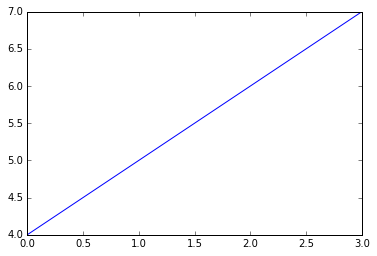

In [36]:
plt.plot(sess.run(model, {x: x_train, y: y_train})) # <3 <3